Agenda
- SVM(Support Vector Machine)支持向量机(线性+非线性分类器) - 核函数：线性，多项式，径向基函数RBF
- 解决数量不平衡问题
- 提取置信度
- 超参数最优化

#### SVM构建线性分类器
- 用线性核函数初始化SVM对象：params = {'kernel': 'linear'}

In [0]:
# SVM构建线性分类器
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_multivar_svm.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1', 'col_2']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

X = np.array(expand_df.iloc[:,:-1])
y = np.array(expand_df.iloc[:,-1])

   col_0  col_1  col_2
0   5.35   4.48      0
1   6.72   5.37      0
2   3.57   5.25      0
3   4.77   7.65      1
4   2.25   4.07      1


Out[154]: Text(0.5, 1.0, 'Input data')

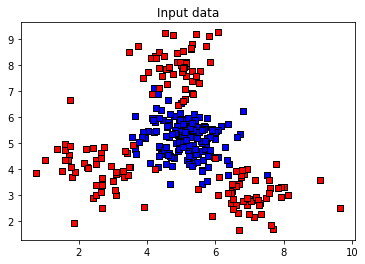

In [0]:
# 先对数据进行可视化，观察不同类别的分布情况
expand_df
class_0=[]
class_1=[]

for i in range(len(expand_df)):
    
    temp = expand_df.iloc[i,0:2].tolist()
    
    if expand_df.iloc[i,2]==0:
        class_0.append(temp)
    else:
        class_1.append(temp)

class_0 = np.array(class_0)
class_1 = np.array(class_1)

# np.vstack((a,b))[:,1]

plt.figure()
plt.scatter(class_0[:,0], class_0[:,1], facecolors='blue', edgecolors='black', marker='s')
plt.scatter(class_1[:,0], class_1[:,1], facecolors='red', edgecolors='black', marker='s')
plt.title('Input data')

In [0]:
# 分类器结果可视化的自定义函数：
# Plot the classifier boundaries on input data
def plot_classifier(classifier, X, y, title='Classifier boundaries', annotate=False):
    # define ranges to plot the figure 
    x_min, x_max = min(X[:, 0]) - 1.0, max(X[:, 0]) + 1.0
    y_min, y_max = min(X[:, 1]) - 1.0, max(X[:, 1]) + 1.0

    # denotes the step size that will be used in the mesh grid
    step_size = 0.01

    # define the mesh grid
    x_values, y_values = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

    # compute the classifier output
    mesh_output = classifier.predict(np.c_[x_values.ravel(), y_values.ravel()])

    # reshape the array
    mesh_output = mesh_output.reshape(x_values.shape)

    # Plot the output using a colored plot 
    plt.figure()

    # Set the title
    plt.title(title)

    # choose a color scheme you can find all the options 
    # here: http://matplotlib.org/examples/color/colormaps_reference.html
    plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)

    # Overlay the training points on the plot 
    plt.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolors='black', linewidth=1, cmap=plt.cm.Dark2)

    # specify the boundaries of the figure
    plt.xlim(x_values.min(), x_values.max())
    plt.ylim(y_values.min(), y_values.max())

    # specify the ticks on the X and Y axes
    plt.xticks(())
    plt.yticks(())

    if annotate:
        for x, y in zip(X[:, 0], X[:, 1]):
            # Full documentation of the function available here: 
            # http://matplotlib.org/api/text_api.html#matplotlib.text.Annotation
            plt.annotate(
                '(' + str(round(x, 1)) + ',' + str(round(y, 1)) + ')',
                xy = (x, y), xytext = (-15, 15), 
                textcoords = 'offset points', 
                horizontalalignment = 'right', 
                verticalalignment = 'bottom', 
                bbox = dict(boxstyle = 'round,pad=0.6', fc = 'white', alpha = 0.8),
                arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))

<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


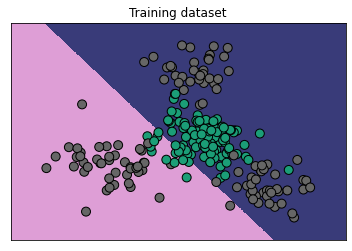

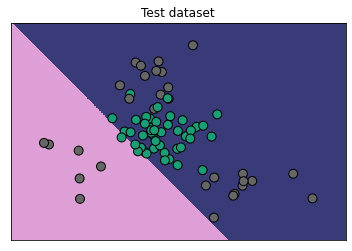

In [0]:
###############################################
# Train test split and SVM training
from sklearn import model_selection
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 定义核函数求解器
params = {'kernel': 'linear'}
# params = {'kernel': 'poly', 'degree': 3}
# params = {'kernel': 'rbf'}

# SVC训练
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 训练结果可视化
plot_classifier(classifier, X_train, y_train, 'Training dataset')

# 测试结果可视化
y_test_pred = classifier.predict(X_test)
plot_classifier(classifier, X_test, y_test, 'Test dataset')

In [0]:
# Evaluate classifier performance - 评估分类器模型性能
from sklearn.metrics import classification_report

target_names = ['Class-' + str(int(i)) for i in set(y)]
print("\n" + "*"*60)
print("\nClassifier performance on training dataset\n")
print(classification_report(y_train, classifier.predict(X_train), target_names=target_names))
print("*"*60 + "\n")

print("*"*60)
print("\nClassification report on test dataset\n")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("*"*60 + "\n")


************************************************************

Classifier performance on training dataset

              precision    recall  f1-score   support

     Class-0       0.55      0.88      0.68       105
     Class-1       0.78      0.38      0.51       120

    accuracy                           0.61       225
   macro avg       0.66      0.63      0.59       225
weighted avg       0.67      0.61      0.59       225

************************************************************

************************************************************

Classification report on test dataset

              precision    recall  f1-score   support

     Class-0       0.64      0.96      0.77        45
     Class-1       0.75      0.20      0.32        30

    accuracy                           0.65        75
   macro avg       0.70      0.58      0.54        75
weighted avg       0.69      0.65      0.59        75

************************************************************



#### SVM构建非线性分类器
- 用多项式方程初始化SVM对象，构建曲线边界：params = {'kernel': 'poly', 'degree': 3}

<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


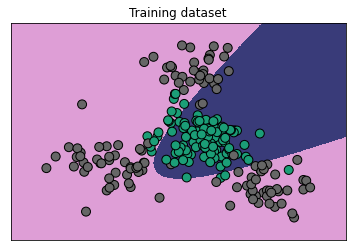

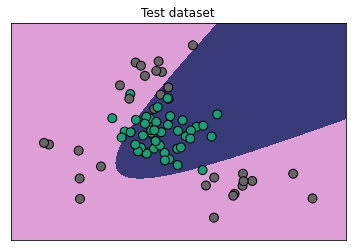

In [0]:
###############################################
# Train test split and SVM training 
from sklearn import model_selection
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 定义核函数求解器
# params = {'kernel': 'linear'}
params = {'kernel': 'poly', 'degree': 3}
# params = {'kernel': 'rbf'}

# SVC训练
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 训练结果可视化
plot_classifier(classifier, X_train, y_train, 'Training dataset')

# 测试结果可视化
y_test_pred = classifier.predict(X_test)
plot_classifier(classifier, X_test, y_test, 'Test dataset')

In [0]:
# Evaluate classifier performance - 评估分类器模型性能
from sklearn.metrics import classification_report

target_names = ['Class-' + str(int(i)) for i in set(y)]
print("\n" + "*"*60)
print("\nClassifier performance on training dataset\n")
print(classification_report(y_train, classifier.predict(X_train), target_names=target_names))
print("*"*60 + "\n")

print("*"*60)
print("\nClassification report on test dataset\n")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("*"*60 + "\n")


************************************************************

Classifier performance on training dataset

              precision    recall  f1-score   support

     Class-0       0.92      0.84      0.88       105
     Class-1       0.87      0.93      0.90       120

    accuracy                           0.89       225
   macro avg       0.89      0.89      0.89       225
weighted avg       0.89      0.89      0.89       225

************************************************************

************************************************************

Classification report on test dataset

              precision    recall  f1-score   support

     Class-0       0.91      0.89      0.90        45
     Class-1       0.84      0.87      0.85        30

    accuracy                           0.88        75
   macro avg       0.87      0.88      0.88        75
weighted avg       0.88      0.88      0.88        75

************************************************************



#### SVM构建非线性分类器
- 用径向基函数(RBF - Radial Basis Function)来初始化SVM对象，构建曲线边界：params = {'kernel': 'rbf'}

<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


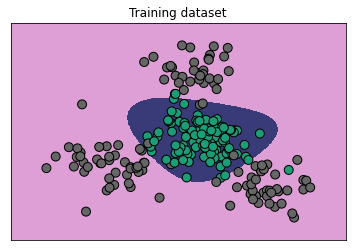

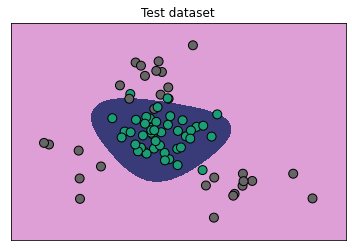

In [0]:
###############################################
# Train test split and SVM training 
from sklearn import model_selection
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 定义核函数求解器
# params = {'kernel': 'linear'}
# params = {'kernel': 'poly', 'degree': 3}
params = {'kernel': 'rbf'}

# SVC训练
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 训练结果可视化
plot_classifier(classifier, X_train, y_train, 'Training dataset')

# 测试结果可视化
y_test_pred = classifier.predict(X_test)
plot_classifier(classifier, X_test, y_test, 'Test dataset')

In [0]:
# Evaluate classifier performance - 评估分类器模型性能
from sklearn.metrics import classification_report

target_names = ['Class-' + str(int(i)) for i in set(y)]
print("\n" + "*"*60)
print("\nClassifier performance on training dataset\n")
print(classification_report(y_train, classifier.predict(X_train), target_names=target_names))
print("*"*60 + "\n")

print("*"*60)
print("\nClassification report on test dataset\n")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("*"*60 + "\n")


************************************************************

Classifier performance on training dataset

              precision    recall  f1-score   support

     Class-0       0.95      0.96      0.96       105
     Class-1       0.97      0.96      0.96       120

    accuracy                           0.96       225
   macro avg       0.96      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225

************************************************************

************************************************************

Classification report on test dataset

              precision    recall  f1-score   support

     Class-0       0.95      0.93      0.94        45
     Class-1       0.90      0.93      0.92        30

    accuracy                           0.93        75
   macro avg       0.93      0.93      0.93        75
weighted avg       0.93      0.93      0.93        75

************************************************************



#### 样本类别不均衡问题
- params{'kernel':'linear','class_weight':'auto'}

In [0]:
# SVM构建线性分类器
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_multivar_imbalance.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

expand_df

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1', 'col_2']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

X = np.array(expand_df.iloc[:,:-1])
y = np.array(expand_df.iloc[:,-1])

   col_0  col_1  col_2
0   4.53   4.75      1
1   5.85   6.26      0
2   2.06   5.18      1
3   7.73   4.04      1
4   4.06   2.52      1


Out[159]: Text(0.5, 1.0, 'Input data')

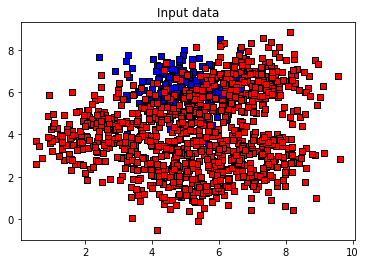

In [0]:
# 先对数据进行可视化，观察不同类别的分布情况
expand_df
class_0=[]
class_1=[]

for i in range(len(expand_df)):
    
    temp = expand_df.iloc[i,0:2].tolist()
    
    if expand_df.iloc[i,2]==0:
        class_0.append(temp)
    else:
        class_1.append(temp)

class_0 = np.array(class_0)
class_1 = np.array(class_1)

# np.vstack((a,b))[:,1]

plt.figure()
plt.scatter(class_0[:,0], class_0[:,1], facecolors='blue', edgecolors='black', marker='s')
plt.scatter(class_1[:,0], class_1[:,1], facecolors='red', edgecolors='black', marker='s')
plt.title('Input data')

<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


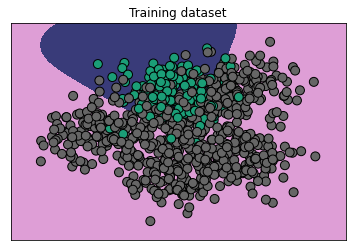

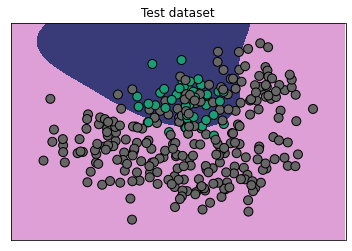

In [0]:
###############################################
# Train test split and SVM training
from sklearn import model_selection
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 定义核函数求解器
# params = {'kernel': 'linear'}
# params = {'kernel': 'poly', 'degree': 3}
# params = {'kernel': 'rbf'}
params = {'kernel':'rbf','class_weight':'balanced'}

# SVC训练
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 训练结果可视化
plot_classifier(classifier, X_train, y_train, 'Training dataset')

# 测试结果可视化
y_test_pred = classifier.predict(X_test)
plot_classifier(classifier, X_test, y_test, 'Test dataset')

In [0]:
# Evaluate classifier performance - 评估分类器模型性能
from sklearn.metrics import classification_report

target_names = ['Class-' + str(int(i)) for i in set(y)]
print("\n" + "*"*60)
print("\nClassifier performance on training dataset\n")
print(classification_report(y_train, classifier.predict(X_train), target_names=target_names))
print("*"*60 + "\n")

print("*"*60)
print("\nClassification report on test dataset\n")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("*"*60 + "\n")


************************************************************

Classifier performance on training dataset

              precision    recall  f1-score   support

     Class-0       0.50      0.93      0.65       158
     Class-1       0.98      0.80      0.88       742

    accuracy                           0.82       900
   macro avg       0.74      0.87      0.77       900
weighted avg       0.90      0.82      0.84       900

************************************************************

************************************************************

Classification report on test dataset

              precision    recall  f1-score   support

     Class-0       0.46      0.88      0.60        42
     Class-1       0.98      0.83      0.90       258

    accuracy                           0.84       300
   macro avg       0.72      0.86      0.75       300
weighted avg       0.90      0.84      0.86       300

************************************************************

